### E-commerce sales log data
* `Motivation`: Cluster different types of customers using basic features from the log sales data

    - Features: Price per product, timestamp, type of product, region, etc.

### Libraries to import

In [107]:
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import plotly.graph_objects as go
from pylab import rcParams
sns.set_theme(style="ticks", palette="pastel")
import calplot
import warnings
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')
%matplotlib inline


### Pandas features to help display the information in a more attractive way

In [1]:
pd.reset_option("max_columns")
pd.set_option("max_colwidth",None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('display.max_columns',50)
pd.set_option('display.width',1000)

### Reading the data from a CSV file

In [2]:
df= pd.read_csv('../data.csv',encoding='latin1')

- Frist look of the dataset and Data exploration

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


- Total amount of observations

In [4]:
print(len(df))

541909


- Top 10 products

In [5]:
df.groupby('Description').agg({'Quantity':'count'}).sort_values(by='Quantity',ascending=False).head(10)

,Quantity
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2369
REGENCY CAKESTAND 3 TIER,2200
JUMBO BAG RED RETROSPOT,2159
PARTY BUNTING,1727
LUNCH BAG RED RETROSPOT,1638
ASSORTED COLOUR BIRD ORNAMENT,1501
SET OF 3 CAKE TINS PANTRY DESIGN,1473
PACK OF 72 RETROSPOT CAKE CASES,1385
LUNCH BAG BLACK SKULL.,1350


- Highest bill invoice note

In [6]:
df.groupby('InvoiceNo').agg({'UnitPrice':'sum'}).sort_values(by='UnitPrice',ascending=False).head(10)

,UnitPrice
InvoiceNo,
C556445,38970.00
C580605,17836.46
C540117,16888.02
C540118,16453.71
537632,13541.33
C537651,13541.33
C537630,13541.33
C537644,13474.79
C580604,11586.50


- Total sales per Country in pounds

In [7]:
df.groupby('Country').agg({'UnitPrice':'sum'}).sort_values(by='UnitPrice',ascending=False).head(10)

,UnitPrice
Country,
United Kingdom,2245715.474
EIRE,48447.190
France,43031.990
Germany,37666.000
Singapore,25108.890
Portugal,13037.540
Spain,12633.450
Hong Kong,12241.500
Belgium,7540.130


- Total sales per country in percentage

In [8]:
total_df= df.groupby('Country').agg({'UnitPrice':'sum'}).sort_values(by='UnitPrice',ascending=False).head(10)
total_df['UnitPrice_p']= (total_df['UnitPrice']/total_df['UnitPrice'].sum())*100
total_df.head()

,UnitPrice,UnitPrice_p
Country,,
United Kingdom,2245715.474,91.578282
EIRE,48447.190,1.975633
France,43031.990,1.754806
Germany,37666.000,1.535986
Singapore,25108.890,1.023918


- Visualization of nan values

In [9]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
no_nan_description=df[~df['Description'].isna()]

- Checking the patterns in the Customer ID column

In [11]:
no_nan_description.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

- Checking a specific value

In [12]:
no_nan_description[no_nan_description['InvoiceNo']=='536544'].tail(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1960,536544,21679,SKULLS STICKERS,3,12/1/2010 14:32,1.66,NaN,United Kingdom
1961,536544,21703,BAG 125g SWIRLY MARBLES,1,12/1/2010 14:32,0.85,NaN,United Kingdom
1962,536544,21704,BAG 250g SWIRLY MARBLES,1,12/1/2010 14:32,1.66,NaN,United Kingdom
1963,536544,21706,FOLDING UMBRELLA RED/WHITE POLKADOT,2,12/1/2010 14:32,10.17,NaN,United Kingdom
1964,536544,21716,BOYS VINTAGE TIN SEASIDE BUCKET,1,12/1/2010 14:32,5.06,NaN,United Kingdom
1965,536544,21721,CANDY SHOP STICKER SHEET,1,12/1/2010 14:32,1.66,NaN,United Kingdom
1966,536544,21722,SWEET PUDDING STICKER SHEET,1,12/1/2010 14:32,1.66,NaN,United Kingdom
1967,536544,21731,RED TOADSTOOL LED NIGHT LIGHT,5,12/1/2010 14:32,3.36,NaN,United Kingdom
1968,536544,21742,LARGE ROUND WICKER PLATTER,1,12/1/2010 14:32,12.72,NaN,United Kingdom
1969,536544,21758,VINTAGE SHELLS PRINT,1,12/1/2010 14:32,12.72,NaN,United Kingdom


In [13]:
no_id_nan= no_nan_description[~no_nan_description['CustomerID'].isna()]

- Lenght of loss regarding the elimination of NaN values

In [14]:
print("Lenght of data after the removal of NAN values:",len(no_id_nan))
print("Original lenght of Data:",len(df))
print("Data after the removal of observations with no nan values:",len(df)-len(no_id_nan))

Lenght of data after the removal of NAN values: 406829
Original lenght of Data: 541909
Data after the removal of observations with no nan values: 135080


- Tabular Visualization of the diference

In [15]:
df_counts= df.groupby('Country').agg({'InvoiceNo':'count'}).sort_values(by='InvoiceNo',ascending=False) # We are counting the amount of invoices that every country has on the total data

In [16]:
no_id_nan_counts= no_id_nan.groupby('Country').agg({'InvoiceNo':'count'}).sort_values(by='InvoiceNo',ascending=False) # We are counting the amount of data in a tabular format without the nan values

- Creating a view from the initial data vs the second tabular data to get the diference column

In [17]:
no_id_nan_counts = no_id_nan_counts.rename(columns={'InvoiceNo': 'no_id_nan_count'})
df_counts = df_counts.rename(columns={'InvoiceNo': 'df_count'})

comparison = no_id_nan_counts.join(df_counts, how='outer') # we have to fill the nan values after the join to make sure that the end values are shown as int
comparison = comparison.fillna(0)
comparison['difference'] =comparison['df_count'] - comparison['no_id_nan_count']

comparison = comparison.astype({"no_id_nan_count":"int","df_count":"int","difference":"int"})

comparison.head(10)

,no_id_nan_count,df_count,difference
Country,,,
Australia,1259,1259,0
Austria,401,401,0
Bahrain,17,19,2
Belgium,2069,2069,0
Brazil,32,32,0
Canada,151,151,0
Channel Islands,758,758,0
Cyprus,622,622,0
Czech Republic,30,30,0


- Searching into nan values in the United Kingdom

In [18]:
united_kingdom_customer_id_nan=df[df['CustomerID'].isna()&(df['Country']=='United Kingdom')]

In [19]:
united_kingdom_customer_id_nan.groupby('InvoiceNo').agg({'Quantity':'count'}).sort_values(by='Quantity',ascending=False)

,Quantity
InvoiceNo,
573585,1114
581219,749
581492,731
580729,721
558475,705
...,...
551701,1
551704,1
551705,1


- Setting the `InvoiceDate` column to date_time

In [20]:
united_kingdom_customer_id_nan['InvoiceDate'] = pd.to_datetime(united_kingdom_customer_id_nan['InvoiceDate'], errors='coerce').copy()

- Organizing the data by day

In [21]:
united_kingdom_customer_id_nan['InvoiceDate'] = united_kingdom_customer_id_nan['InvoiceDate'].dt.date
united_kingdom_customer_id_nan.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01,1.66,NaN,United Kingdom


- Groupby for InvoiceDate and InvoiceNo

In [22]:
result = (united_kingdom_customer_id_nan
          .groupby(['InvoiceDate', 'InvoiceNo'])
          .agg({'Quantity': 'count'})
          .sort_values(['InvoiceDate', 'Quantity'], ascending=False)).copy()
result.head()

Quantity
InvoiceDate InvoiceNo          
2011-12-09  581492          731
            581498          218
            581497           59
2011-12-08  581219          749
            581217          676

- Groupby by InvoiceDate and Quantity

In [23]:
result_2 = (united_kingdom_customer_id_nan
          .groupby(['InvoiceDate'])
          .agg({'Quantity': 'count'})
          .sort_values('InvoiceDate', ascending=True))
result_2.head()


,Quantity
InvoiceDate,
2010-12-01,1140
2010-12-02,65
2010-12-03,1074
2010-12-05,1
2010-12-06,1904


- Visualization of nan values

In [24]:
print("Total nan values",len(no_id_nan))
print("-"*50)
print("More descriptive visualization of nan values\n\n",
      no_id_nan.isna().sum())

Total nan values 406829
--------------------------------------------------
More descriptive visualization of nan values

 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


- Resetting the dataframe to df

In [25]:
df=no_id_nan.copy()

In [26]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


- Looking for the Product with the maximum price
    - So far the quantity shown reflects "-1" which we can assume is a devolution

In [27]:
max_price= np.max(df['UnitPrice'])

In [28]:
df_max_price = df[df['UnitPrice'] == max_price]

In [29]:
df_max_price

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,6/10/2011 15:31,38970.0,15098.0,United Kingdom


- Looking for any anomally in the StockCode column

In [30]:
df.StockCode.value_counts()

StockCode
85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
          ... 
84620        1
90038B       1
84551        1
84614A       1
20957        1
Name: count, Length: 3684, dtype: int64

- Basic stats in tabular format of the data

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


- Basic information of the dataset

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


- Feature engineering over time data to create more columns

In [33]:
def create_time_features(df:pd.DataFrame)-> pd.DataFrame:
    df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
    df.sort_values(by='InvoiceDate',inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index('InvoiceDate',inplace=True)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    return df

df_time_features = create_time_features(df)

In [34]:
df_time_features.head(10)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year
InvoiceDate,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,7.65,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:28:00,536366,22633,HAND WARMER UNION JACK,6,1.85,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:28:00,536366,22632,HAND WARMER RED POLKA DOT,6,1.85,17850.0,United Kingdom,2010,12,1,2,335,48


- Visualization of Time series data of sales over the time on different countries

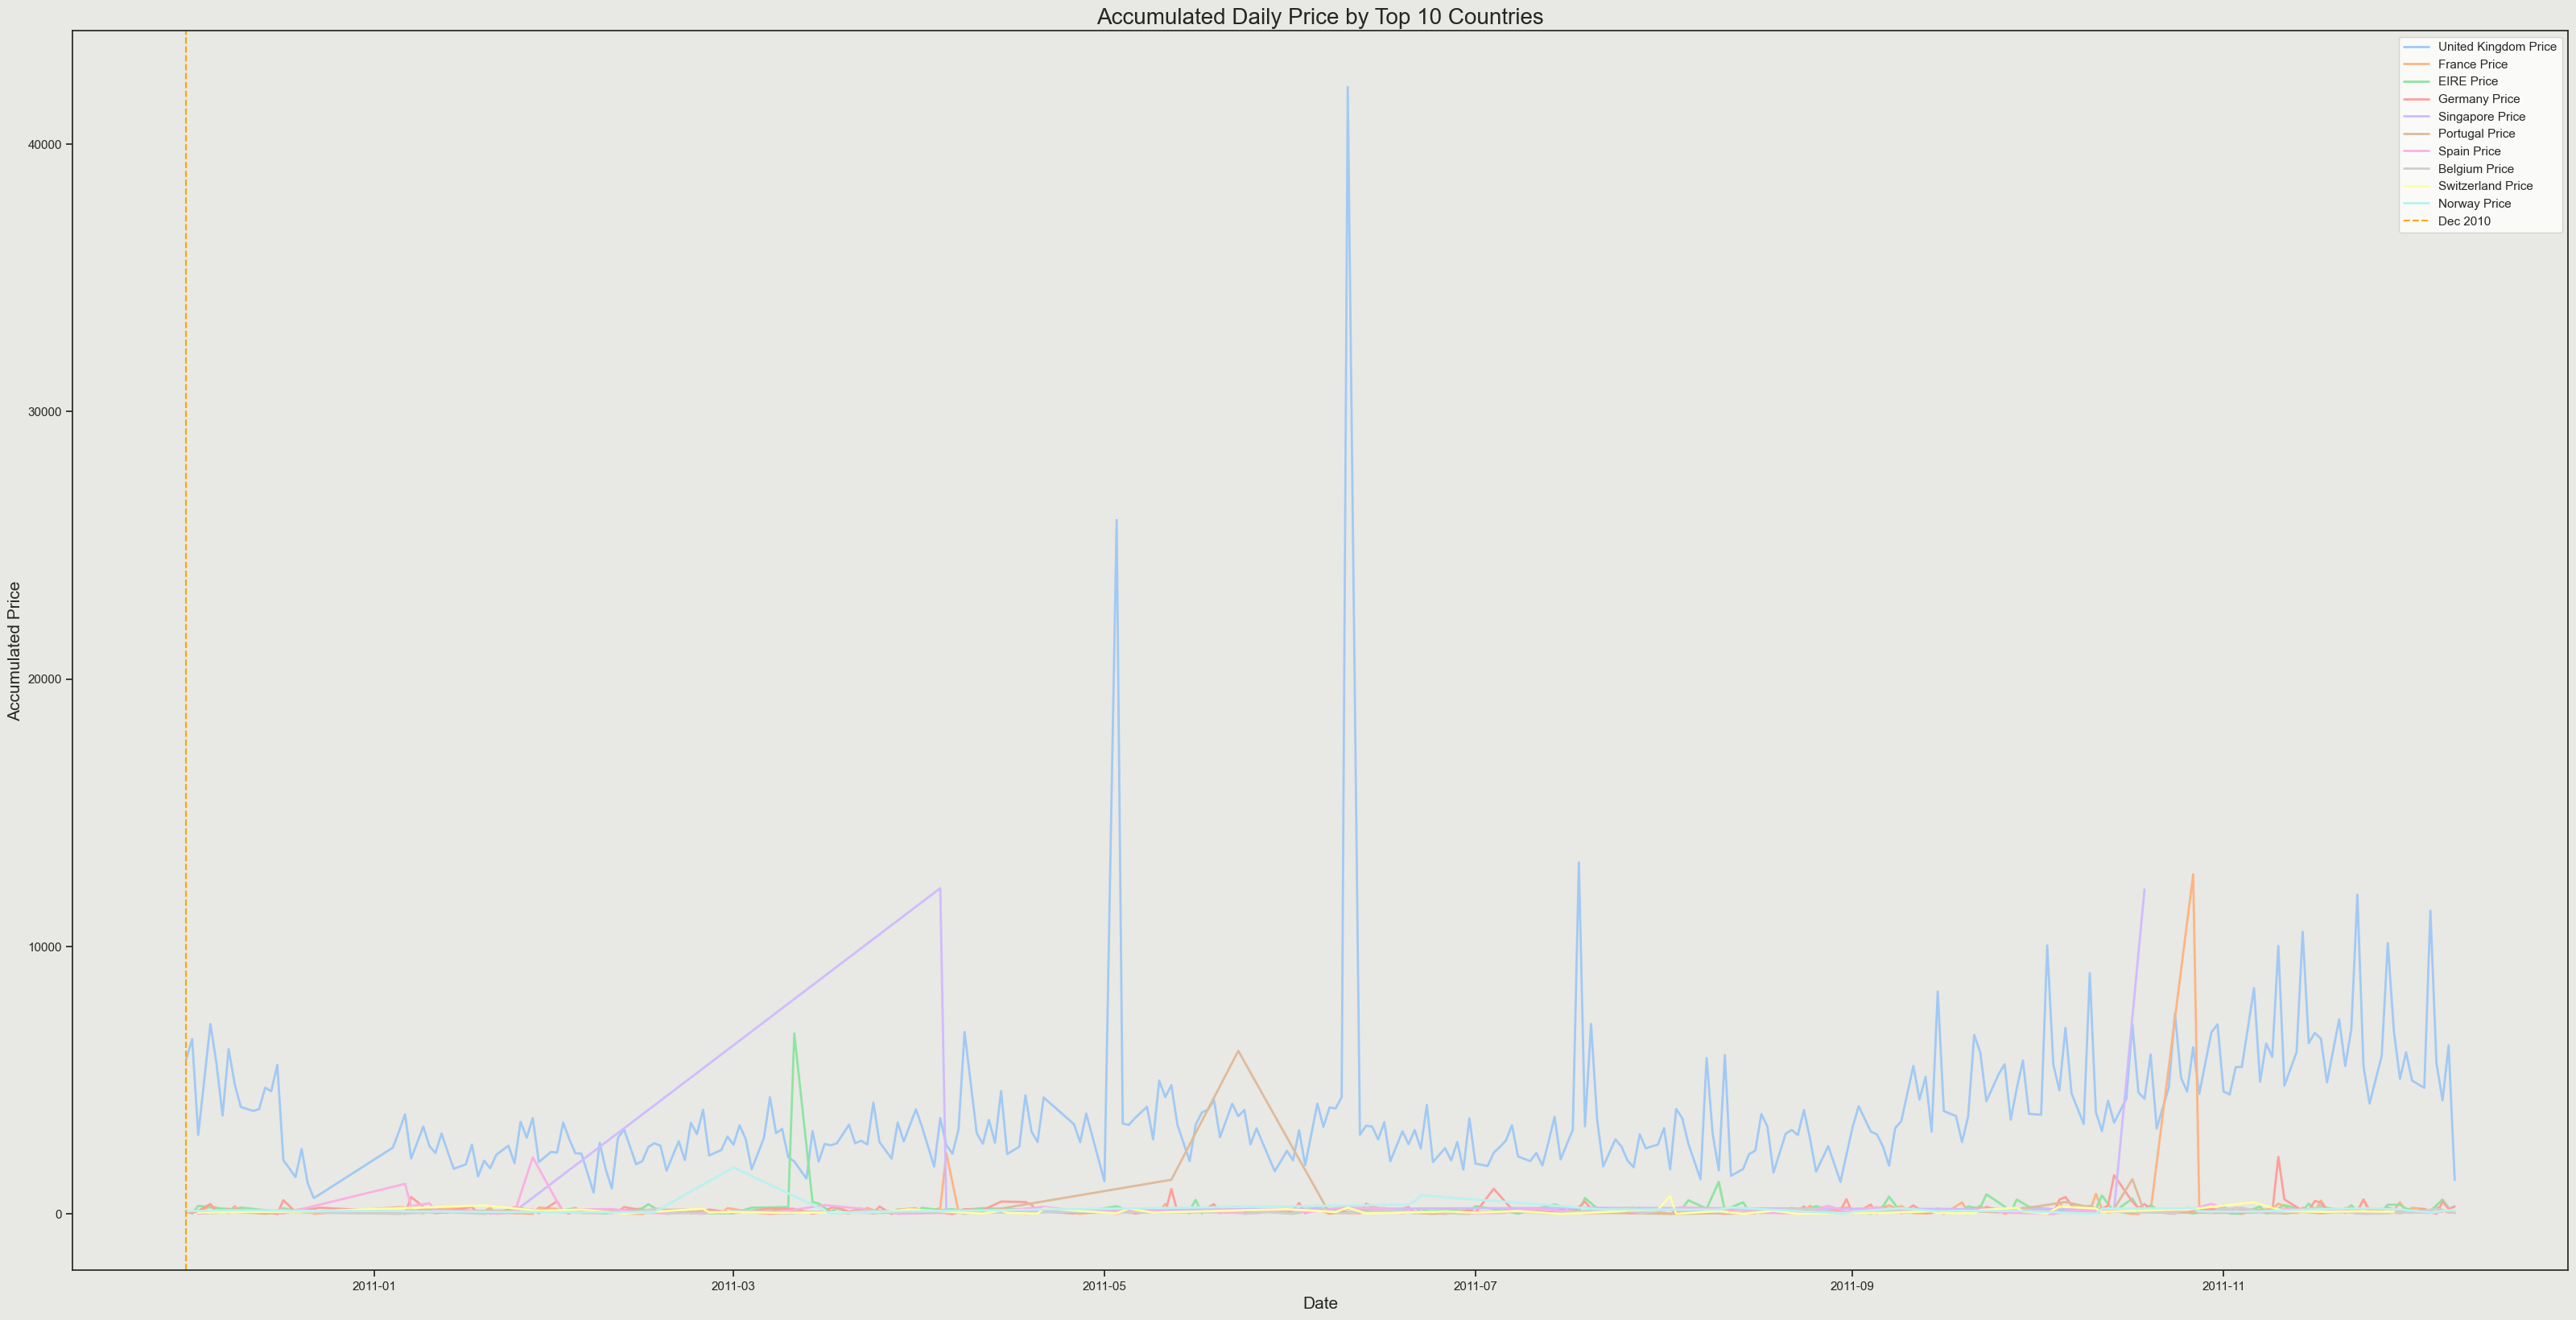

In [35]:
top_countries = (df_time_features.groupby('Country')['UnitPrice']
                 .sum()
                 .nlargest(10)
                 .index)

plt.figure(figsize=(40, 20))

for country in top_countries:
    country_data = df_time_features[df_time_features['Country'] == country]
    
    country_plot = country_data.groupby(country_data.index.date).agg({'UnitPrice': 'sum'})
    
    country_plot["UnitPrice"].plot(label=f"{country} Price", linewidth=2)


plt.axvline(x=pd.to_datetime('2010-12'), color='orange', linestyle='--', label='Dec 2010')
plt.title("Accumulated Daily Price by Top 10 Countries", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Accumulated Price", fontsize=15)
plt.legend(title="Country", loc="upper left")
plt.gca().set_facecolor('#E8E8E4')  
plt.gcf().set_facecolor('#E8E8E4')
plt.legend(facecolor='#E8E8E4')
plt.legend()
plt.show()
plt.show()

- Visualization of the length of data and duplicated data

In [36]:
print("Total length of data",len(df))
print("Lenght of duplicated data",len(df[df.duplicated()]))

Total length of data 406829
Lenght of duplicated data 5226


In [37]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")
df.drop_duplicates(inplace=True)

The dataset contains 5226 duplicate rows that need to be removed.


### Looking for anomallies in data on the Quantity and UnitPrice column

    - We can infer that the "-1" items are devolutions

In [38]:
df[df['Quantity']<=0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year
InvoiceDate,,,,,,,,,,,,,
2010-12-01 09:41:00,C536379,D,Discount,-1,27.50,14527.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 09:49:00,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 10:24:00,C536391,22553,PLASTERS IN TIN SKULLS,-24,1.65,17548.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 10:24:00,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,3.45,17548.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 10:24:00,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,17548.0,United Kingdom,2010,12,1,2,335,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 09:57:00,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397.0,United Kingdom,2011,12,9,4,343,49
2011-12-09 10:28:00,C581499,M,Manual,-1,224.69,15498.0,United Kingdom,2011,12,9,4,343,49
2011-12-09 11:57:00,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311.0,United Kingdom,2011,12,9,4,343,49


- Why do we have values in `UnitPrice` with 0.0?

    - We do not have any information about "Promotions", in future data sales log we can add a feature called "Promotion" with a binary value to flag if is a promotion or not

In [39]:
df[df['UnitPrice']<=0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year
InvoiceDate,,,,,,,,,,,,,
2010-12-05 14:02:00,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,0.0,12647.0,Germany,2010,12,5,6,339,48
2010-12-16 14:36:00,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,0.0,16560.0,United Kingdom,2010,12,16,3,350,50
2010-12-21 13:45:00,539722,22423,REGENCY CAKESTAND 3 TIER,10,0.0,14911.0,EIRE,2010,12,21,1,355,51
2011-01-06 16:41:00,540372,22553,PLASTERS IN TIN SKULLS,24,0.0,13081.0,United Kingdom,2011,1,6,3,6,1
2011-01-06 16:41:00,540372,22090,PAPER BUNTING RETROSPOT,24,0.0,13081.0,United Kingdom,2011,1,6,3,6,1


- Feature engineering with the - InvoiceNo - column to "decrypt" the meaning of the Quantity column. if the Observation in the - InvoiceNo - starts with C we can say that is Cancelled, otherwise is complete

In [40]:
df['Transaction_status']= np.where(df['InvoiceNo'].astype(str).str.startswith('C'),'Cancelled','Complete')

- Double-checking the data and seeing that all the observations have a "-" value in the column Quantity

In [41]:
df[df['Transaction_status']=='Cancelled']

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status
InvoiceDate,,,,,,,,,,,,,,
2010-12-01 09:41:00,C536379,D,Discount,-1,27.50,14527.0,United Kingdom,2010,12,1,2,335,48,Cancelled
2010-12-01 09:49:00,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010,12,1,2,335,48,Cancelled
2010-12-01 10:24:00,C536391,22553,PLASTERS IN TIN SKULLS,-24,1.65,17548.0,United Kingdom,2010,12,1,2,335,48,Cancelled
2010-12-01 10:24:00,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,3.45,17548.0,United Kingdom,2010,12,1,2,335,48,Cancelled
2010-12-01 10:24:00,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,17548.0,United Kingdom,2010,12,1,2,335,48,Cancelled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 09:57:00,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397.0,United Kingdom,2011,12,9,4,343,49,Cancelled
2011-12-09 10:28:00,C581499,M,Manual,-1,224.69,15498.0,United Kingdom,2011,12,9,4,343,49,Cancelled
2011-12-09 11:57:00,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311.0,United Kingdom,2011,12,9,4,343,49,Cancelled


In [42]:
df[df['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status
InvoiceDate,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22555,PLASTERS IN TIN STRONGMAN,12,1.65,12680.0,France,2011,12,9,4,343,49,Complete
2011-12-09 12:50:00,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,12680.0,France,2011,12,9,4,343,49,Complete
2011-12-09 12:50:00,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680.0,France,2011,12,9,4,343,49,Complete


- Visualization of 0 values

In [43]:
print("Total values on our dataset:",len(df))
print("Total amount of observations with Quantity over 0:",len(df[df['Quantity']>0]))
print("Total amount of observations with Quantity under 0:",len(df[df['Quantity']<=0]))

Total values on our dataset: 401603
Total amount of observations with Quantity over 0: 392731
Total amount of observations with Quantity under 0: 8872


- Percentage of cancelled data

In [44]:
cancelled= df[df['Transaction_status']=='Cancelled']
percentage_cancelled= round((cancelled.shape[0]/df.shape[0])*100,2)

In [45]:
print(f"The percentage of transactions cancelled in the dataset is: {percentage_cancelled}")

The percentage of transactions cancelled in the dataset is: 2.21


- What is the `StockCode` POST as seen on index 30?

In [46]:
unique_stock_codes = df['StockCode'].unique()
total = pd.Series(unique_stock_codes)
total[20:40]

20    22749
21    22748
22    22745
23    84879
24    22622
25    21756
26    22661
27    21731
28    22900
29    22492
30    22540
31    22544
32    22631
33     POST
34    21913
35    22659
36    21791
37    22326
38    21035
39    10002
dtype: object

- Looking for Stock codes with anomalies
    - In this line of code we are counting the amount of `StockCode` observations by the amount of letters

In [47]:
anomlies_code= pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

In [48]:
print(anomlies_code)

5    3676
0       7
1       1
Name: count, dtype: int64


- Filtering observations "Next day Carriage" and "High Resolution Image"

In [49]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"] #Creating filter for description

In [50]:
df= df[~df['Description'].isin(service_related_descriptions)]

In [51]:
print(len(df)) #Total length

401520


- Types of anomalous `StockCodes`

In [52]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]
print(anomalous_stock_codes)
print("Amount of anomaloues codes:",len(anomalous_stock_codes))

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']
Amount of anomaloues codes: 8


- Filtering in a new dataframe without the anomalous codes

In [53]:
df= df[~df['StockCode'].isin(anomalous_stock_codes)]

- New lenght of the dataframe

In [54]:
print(len(df))

399605


- Making Date column organized by day

In [55]:
df['Date']= df.index.date

### Feature engineering regarding Datetime columns


- This is beginning of the feature engineering using datetime

In [56]:
customer_data=df.groupby('CustomerID')['Date'].max().reset_index()
most_recent_data= df['Date'].max()
customer_data['Date']= pd.to_datetime(customer_data['Date'])
most_recent_data= pd.to_datetime(most_recent_data)

In [57]:
most_recent_data # Filtering the data with the highest date

Timestamp('2011-12-09 00:00:00')

In [58]:
customer_data # Orginal data orginized by customer id to check the last date of use

,CustomerID,Date
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02
...,...,...
4358,18280.0,2011-03-07
4359,18281.0,2011-06-12
4360,18282.0,2011-12-02
4361,18283.0,2011-12-06


- We are going to create a feature called "last_date_transaction" where we are going to measure in days the amount of days since the last transaction

In [59]:
customer_data['last_date_transaction']=(most_recent_data-customer_data['Date']).dt.days
customer_data.drop(columns='Date',inplace=True)

- Amount of days since the last transaction

In [60]:
customer_data.head()

,CustomerID,last_date_transaction
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [61]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo':'Total_transactions'},inplace=True)

In [62]:
total_transactions.head() # Total amount of transactions per CustomerID

,CustomerID,Total_transactions
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [63]:
total_products_purchased= df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity':'Total_products_porchased'},inplace=True)

In [64]:
total_products_purchased.head() # Total amount of products purchased per CustomerID

,CustomerID,Total_products_porchased
0,12346.0,0
1,12347.0,2458
2,12348.0,2332
3,12349.0,630
4,12350.0,196


In [65]:
customer_data= pd.merge(customer_data,total_transactions,on="CustomerID")
customer_data= pd.merge(customer_data,total_products_purchased,on="CustomerID")
customer_data.head(2) # Data orginized by CustomerID with last transaction date, Total transactions per CustomerID and total products purchased.

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased
0,12346.0,325,2,0
1,12347.0,2,7,2458


In [66]:
df['total_spend']= (df['UnitPrice']*df['Quantity'])
df.head() # Data with the feature total spend per CustomerID

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status,Date,total_spend
InvoiceDate,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,20.34


In [67]:
total_spend = df.groupby('CustomerID')['total_spend'].sum().reset_index()

In [68]:
total_spend.head() # Total spend per user

,CustomerID,total_spend
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40


- Creating the `Average_transaction_value` feature with `total_spend`and `Total_transactions`

In [69]:
average_transaction_value = total_spend.merge(total_transactions,on="CustomerID")
average_transaction_value['Average_transaction_value'] = round(average_transaction_value["total_spend"] / average_transaction_value['Total_transactions'],2)

In [70]:
average_transaction_value.head()

,CustomerID,total_spend,Total_transactions,Average_transaction_value
0,12346.0,0.00,2,0.00
1,12347.0,4310.00,7,615.71
2,12348.0,1437.24,4,359.31
3,12349.0,1457.55,1,1457.55
4,12350.0,294.40,1,294.40


In [72]:
customer_data= pd.merge(customer_data,average_transaction_value[['CustomerID','Average_transaction_value','total_spend']],on="CustomerID")
customer_data.head() # Gathering more information from the same sales data

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased,Average_transaction_value,total_spend
0,12346.0,325,2,0,0.00,0.00
1,12347.0,2,7,2458,615.71,4310.00
2,12348.0,75,4,2332,359.31,1437.24
3,12349.0,18,1,630,1457.55,1457.55
4,12350.0,310,1,196,294.40,294.40


- Unique products purchased

In [73]:
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.head()

,CustomerID,StockCode
0,12346.0,1
1,12347.0,103
2,12348.0,21
3,12349.0,72
4,12350.0,16


In [74]:
unique_products_purchased.rename(columns={'StockCode':'Unique_products_purchased'},inplace=True)
unique_products_purchased.head(2)

,CustomerID,Unique_products_purchased
0,12346.0,1
1,12347.0,103


- Adding the information to customer_data

In [75]:
customer_data = pd.merge(customer_data,unique_products_purchased,on='CustomerID')

- Feature engineering from DatetimeIndex

In [76]:
df['Hour']= df.index.hour

In [77]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status,Date,total_spend,Hour
InvoiceDate,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,15.30,8
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,20.34,8


- Creating the `Average_Days_Between_Purchases` feature

In [78]:
days_between_purchases = df.groupby('CustomerID')['Date'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'Date': 'Average_Days_Between_Purchases'}, inplace=True)

- Creates a favorite shopping day from the dataframe

    - The next groupby will create a new dataframe where we count the amount of occurences that we have per CustomerID
    - size() and reset_index(name='Count') will give the column a name and will assign an index number to the new dataframe

In [79]:
favorite_shopping_day = df.groupby(['CustomerID','day_of_week']).size().reset_index(name='Count')
favorite_shopping_day.head()

,CustomerID,day_of_week,Count
0,12346.0,1,2
1,12347.0,0,47
2,12347.0,1,53
3,12347.0,2,40
4,12347.0,3,42


- Once we have that data, we are going to select the day of the week where the CustomerID had the highest number of `Count`

In [80]:
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID','day_of_week']]
favorite_shopping_day.head()

,CustomerID,day_of_week
0,12346.0,1
2,12347.0,1
6,12348.0,3
8,12349.0,0
9,12350.0,2


- The process is the same for the favorite hour of buying

In [83]:
favorite_shopping_hour = df.groupby(['CustomerID','Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID','Hour']]
favorite_shopping_hour.head()

,CustomerID,Hour
0,12346.0,10
5,12347.0,14
9,12348.0,19
10,12349.0,9
11,12350.0,16


- All the data is merged together

In [84]:
customer_data= pd.merge(customer_data,average_days_between_purchases,on='CustomerID')
customer_data= pd.merge(customer_data,favorite_shopping_day,on='CustomerID')
customer_data= pd.merge(customer_data,favorite_shopping_hour,on='CustomerID')
customer_data.head()

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased,Average_transaction_value,total_spend,Unique_products_purchased,Average_Days_Between_Purchases,day_of_week,Hour
0,12346.0,325,2,0,0.00,0.00,1,0.00,1,10
1,12347.0,2,7,2458,615.71,4310.00,103,2.02,1,14
2,12348.0,75,4,2332,359.31,1437.24,21,10.88,3,19
3,12349.0,18,1,630,1457.55,1457.55,72,0.00,0,9
4,12350.0,310,1,196,294.40,294.40,16,0.00,2,16


- Counting the amount of transactions per `CustomerID` and organized by `Country`

In [81]:
customer_country = df.groupby(['CustomerID','Country']).size().reset_index(name='Number_of_transactions')
customer_country.head()

,CustomerID,Country,Number_of_transactions
0,12346.0,United Kingdom,2
1,12347.0,Iceland,182
2,12348.0,Finland,27
3,12349.0,Italy,72
4,12350.0,Norway,16


In [82]:
customer_main_country = customer_country.sort_values('Number_of_transactions',ascending=False).drop_duplicates('CustomerID')
customer_main_country.head()

,CustomerID,Country,Number_of_transactions
4042,17841.0,United Kingdom,7800
1900,14911.0,EIRE,5808
1305,14096.0,United Kingdom,5095
336,12748.0,United Kingdom,4440
1679,14606.0,United Kingdom,2755


- Creation of a binary column called `uk`

In [83]:
customer_main_country['uk'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

- Merging the data to customer_data

In [84]:
customer_data = pd.merge(customer_data,customer_main_country[['CustomerID','uk']],on='CustomerID',how='left')

- Creating `Cancelled_frequency` column to later on create `cancelation_rate`

In [85]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancelled_transactions = df[df['Transaction_status']=='Cancelled']
cancelled_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancelled_frequency.rename(columns={'InvoiceNo':'Cancelled_frequency'},inplace=True)

In [86]:
customer_data = pd.merge(customer_data,cancelled_frequency, on='CustomerID',how='left')
customer_data['Cancelled_frequency'].fillna(0,inplace=True)
customer_data['cancelation_rate']= customer_data['Cancelled_frequency']/total_transactions['InvoiceNo']

In [87]:
customer_data.head()

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased,Average_transaction_value,total_spend,Unique_products_purchased,uk,Cancelled_frequency,cancelation_rate
0,12346.0,325,2,0,0.00,0.00,1,1,1.0,0.5
1,12347.0,2,7,2458,615.71,4310.00,103,0,0.0,0.0
2,12348.0,75,4,2332,359.31,1437.24,21,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.55,72,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.40,16,0,0.0,0.0


- Grouping by `total_spend`

In [88]:
monthly_spend = df.groupby(['CustomerID','year','month'])['total_spend'].sum().reset_index()
monthly_spend

,CustomerID,year,month,total_spend
0,12346.0,2011,1,0.00
1,12347.0,2010,12,711.79
2,12347.0,2011,1,475.39
3,12347.0,2011,4,636.25
4,12347.0,2011,6,382.52
...,...,...,...,...
13617,18283.0,2011,10,112.99
13618,18283.0,2011,11,637.71
13619,18283.0,2011,12,208.00
13620,18287.0,2011,5,765.28


- in Seasonal pattern, we create a column called monthly_total_mean and monthly_total_std to gather seasonal patterns from each Customer

In [89]:
seasonal_pattern = monthly_spend.groupby('CustomerID')['total_spend'].agg(['mean','std']).reset_index()
seasonal_pattern.rename(columns={'mean':'monthly_total_mean','std':'monthly_total_std'},inplace=True)

In [91]:
seasonal_pattern.head() # Seasonal pattern of the data

,CustomerID,monthly_total_mean,monthly_total_std
0,12346.0,0.000000,NaN
1,12347.0,615.714286,341.070789
2,12348.0,359.310000,203.875689
3,12349.0,1457.550000,NaN
4,12350.0,294.400000,NaN


In [92]:
seasonal_pattern['monthly_total_std'].fillna(0,inplace=True)

In [93]:
def calculate_slope(spend_data):
    """Calculate the slope of a linear regression line for spending data over time.

    This function computes the slope coefficient of a simple linear regression
    where x is the time index and y is the spend amount. If there is only one
    data point or less, returns 0.

        spend_data (numpy.ndarray): Array of numerical spending values over time

        float: Slope coefficient of the linear regression line. Returns 0 if input
            contains 1 or fewer points.
   _summary_

    Args:
        spend_data (_type_):Total spend per user

    Returns:
        _type_: Spending trend slope
    """
    if len(spend_data) > 1:
        x= np.arange(len(spend_data))
        slope,_,_,_,_= linregress(x,spend_data)
        return slope
    else:
        return 0

- data_with_slope has the information of the spending trend of every `CustomerID` it calculate the slope overtime

In [96]:
data_with_slope = monthly_spend.groupby('CustomerID')['total_spend'].apply(calculate_slope).reset_index()
data_with_slope.rename(columns={'total_spend':'spending_trend'},inplace=True)

In [97]:
customer_data= pd.merge(customer_data,seasonal_pattern,on='CustomerID')
customer_data= pd.merge(customer_data,data_with_slope,on='CustomerID')
customer_data.head(10)

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased,Average_transaction_value,total_spend,Unique_products_purchased,uk,Cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.00,0.00,1,1,1.0,0.500,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,615.71,4310.00,103,0,0.0,0.000,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,359.31,1437.24,21,0,0.0,0.000,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.55,72,0,0.0,0.000,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.40,16,0,0.0,0.000,294.400000,0.000000,0.000000
5,12352.0,36,8,463,158.18,1265.41,57,0,1.0,0.125,316.352500,134.700629,9.351000
6,12353.0,204,1,20,89.00,89.00,4,0,0.0,0.000,89.000000,0.000000,0.000000
7,12354.0,232,1,530,1079.40,1079.40,58,0,0.0,0.000,1079.400000,0.000000,0.000000
8,12355.0,214,1,240,459.40,459.40,13,0,0.0,0.000,459.400000,0.000000,0.000000
9,12356.0,22,3,1573,829.14,2487.43,52,0,0.0,0.000,829.143333,991.462585,-944.635000


- Making all the name of the columns to lower case

In [98]:
def lowering_columns(df:pd.DataFrame)->pd.DataFrame:
    df.columns= df.columns.str.lower()
    return df

In [99]:
total_data= lowering_columns(customer_data)

In [100]:
total_data.head()

,customerid,last_date_transaction,total_transactions,total_products_porchased,average_transaction_value,total_spend,unique_products_purchased,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.00,0.00,1,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,615.71,4310.00,103,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,359.31,1437.24,21,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.55,72,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.40,16,0,0.0,0.0,294.400000,0.000000,0.000000


- Using conver_dtypes() for giving a proper type to every column

In [101]:
total_data['customerid']= total_data['customerid'].astype(str)
total_data= total_data.convert_dtypes()

In [102]:
total_data.head()

,customerid,last_date_transaction,total_transactions,total_products_porchased,average_transaction_value,total_spend,unique_products_purchased,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.0,0.0,1,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,615.71,4310.0,103,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,359.31,1437.24,21,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0,0,0.0,294.4,0.0,0.0


- Case Study: Anomally detection

    - Using an isolation forest to give an outlier score to the observations, to know if they are regular or not

In [103]:
model= IsolationForest(contamination=0.05,random_state=42)
total_data['outlier_score']= model.fit_predict(total_data.iloc[:,1:].to_numpy())
total_data.head()

,customerid,last_date_transaction,total_transactions,total_products_porchased,average_transaction_value,total_spend,unique_products_purchased,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend,outlier_score
0,12346.0,325,2,0,0.0,0.0,1,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,615.71,4310.0,103,0,0,0.0,615.714286,341.070789,4.486071,1
2,12348.0,75,4,2332,359.31,1437.24,21,0,0,0.0,359.31,203.875689,-100.884,1
3,12349.0,18,1,630,1457.55,1457.55,72,0,0,0.0,1457.55,0.0,0.0,-1
4,12350.0,310,1,196,294.4,294.4,16,0,0,0.0,294.4,0.0,0.0,1


- Creating a binary class¡fication called `is_outlier` 

In [104]:
total_data['is_outlier']= [1 if x == -1 else 0 for x in total_data['outlier_score']]
total_data.head()

,customerid,last_date_transaction,total_transactions,total_products_porchased,average_transaction_value,total_spend,unique_products_purchased,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend,outlier_score,is_outlier
0,12346.0,325,2,0,0.0,0.0,1,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,615.71,4310.0,103,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,359.31,1437.24,21,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0,0,0.0,1457.55,0.0,0.0,-1,1
4,12350.0,310,1,196,294.4,294.4,16,0,0,0.0,294.4,0.0,0.0,1,0


- 5% of the data are outliers

In [105]:
total_data['is_outlier'].value_counts(normalize=True)*100

is_outlier
0    94.980518
1     5.019482
Name: proportion, dtype: float64

- Only working with non outlier data

In [106]:
total_data_cleaned = total_data[total_data['is_outlier'] == 0]

- Cleaning the unnecesary columns

In [107]:
total_data_cleaned = total_data_cleaned.drop(columns=['is_outlier','outlier_score'])
total_data_cleaned.reset_index(drop=True,inplace=True)
total_data_cleaned.shape[0]

4144

- Visualization of the correlation within the data

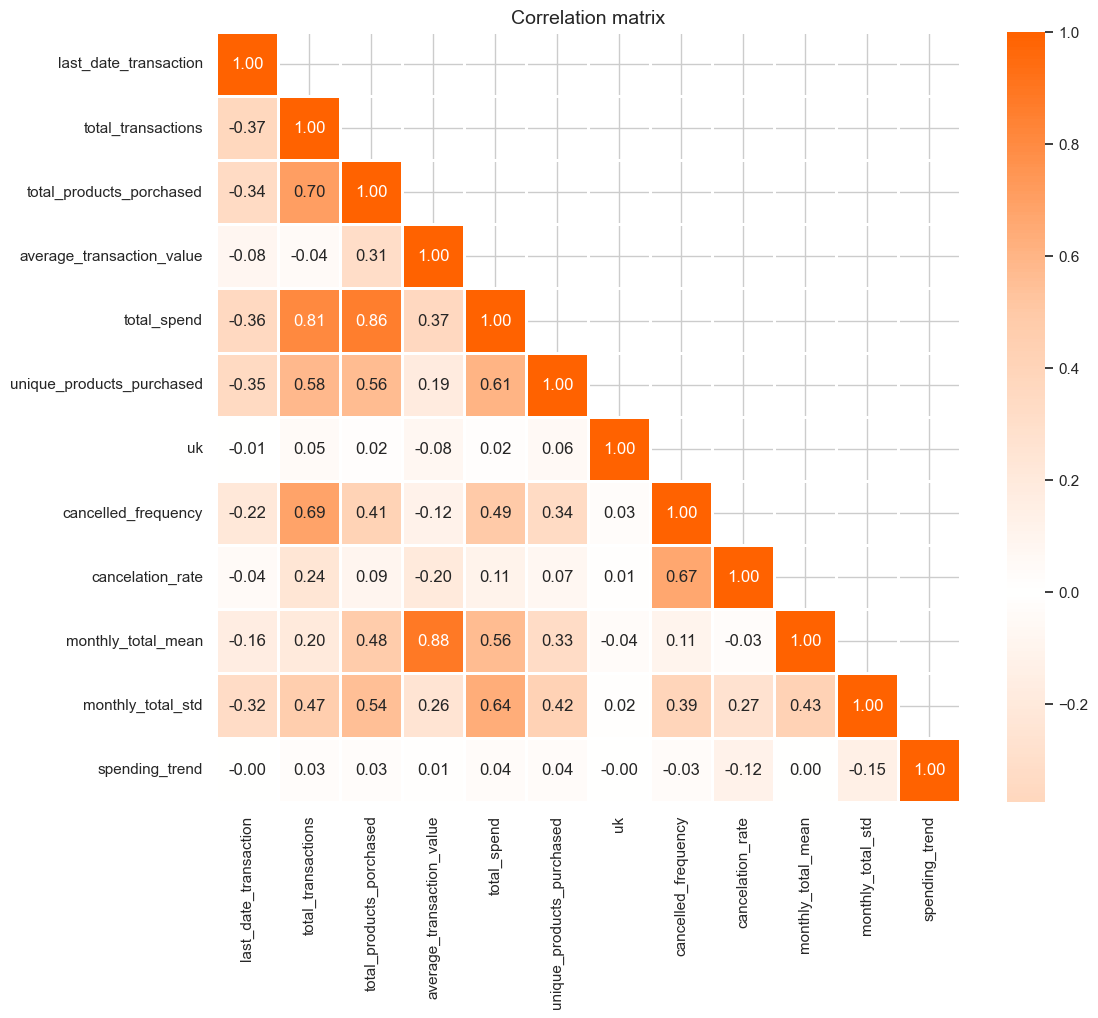

In [108]:
sns.set_style('whitegrid')
coor= total_data_cleaned.drop(columns='customerid').corr()
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_corr_map = LinearSegmentedColormap.from_list('custom_map',colors,N=256)
mask= np.zeros_like(coor)
mask[np.triu_indices_from(mask,k=1)] = True
plt.figure(figsize=(12,10))
sns.heatmap(coor,mask=mask,cmap=my_corr_map, annot=True, center=0,fmt='.2f',linewidths=2)
plt.title('Correlation matrix',fontsize=14)
plt.show()

In [109]:
total_data_cleaned.head()

,customerid,last_date_transaction,total_transactions,total_products_porchased,average_transaction_value,total_spend,unique_products_purchased,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.0,0.0,1,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,615.71,4310.0,103,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,359.31,1437.24,21,0,0,0.0,359.31,203.875689,-100.884
3,12350.0,310,1,196,294.4,294.4,16,0,0,0.0,294.4,0.0,0.0
4,12352.0,36,8,463,158.18,1265.41,57,0,1,0.125,316.3525,134.700629,9.351


- Scaling the data 

In [110]:
scaler = StandardScaler()
columns_to_exclude = ['customerid','uk','day_of_week']
columns_to_scale =total_data_cleaned.columns.difference(columns_to_exclude)
customer_data_scaled = total_data_cleaned.copy()
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])
customer_data_scaled.head(10)

,customerid,last_date_transaction,total_transactions,total_products_porchased,average_transaction_value,total_spend,unique_products_purchased,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,2.311235,-0.466192,-0.738938,-1.321056,-0.803538,-0.872962,1,0.357827,2.335720,-1.335450,-0.712020,0.082347
1,12347.0,-0.905655,0.650900,1.937281,1.569732,2.318203,0.781296,0,-0.519590,-0.585747,1.020570,1.293049,0.109435
2,12348.0,-0.178618,-0.019355,1.800095,0.365922,0.237458,-0.548598,0,-0.519590,-0.585747,0.039444,0.486514,-0.526810
3,12350.0,2.161844,-0.689610,-0.525537,0.061166,-0.590303,-0.629689,0,-0.519590,-0.585747,-0.208933,-0.712020,0.082347
4,12352.0,-0.567035,0.874318,-0.234833,-0.578393,0.113001,0.035258,0,0.357827,0.144620,-0.124932,0.079851,0.138811
5,12353.0,1.106146,-0.689610,-0.717162,-0.903196,-0.739075,-0.824307,0,-0.519590,-0.585747,-0.994893,-0.712020,0.082347
6,12354.0,1.385010,-0.689610,-0.161885,3.746779,-0.021726,0.051476,0,-0.519590,-0.585747,2.794856,-0.712020,0.082347
7,12355.0,1.205740,-0.689610,-0.477631,0.835849,-0.470793,-0.678343,0,-0.519590,-0.585747,0.422436,-0.712020,0.082347
8,12358.0,-0.915615,-0.466192,-0.475453,0.857587,-0.131342,-0.694562,0,-0.519590,-0.585747,0.440153,-0.220092,0.796908
9,12360.0,-0.407685,-0.242773,0.519691,2.281689,0.863849,0.797514,0,-0.519590,-0.585747,1.600815,0.879744,0.082951


In [111]:
customer_data_scaled.set_index('customerid', inplace=True)
customer_data_scaled.head()

,last_date_transaction,total_transactions,total_products_porchased,average_transaction_value,total_spend,unique_products_purchased,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
customerid,,,,,,,,,,,,
12346.0,2.311235,-0.466192,-0.738938,-1.321056,-0.803538,-0.872962,1,0.357827,2.335720,-1.335450,-0.712020,0.082347
12347.0,-0.905655,0.650900,1.937281,1.569732,2.318203,0.781296,0,-0.519590,-0.585747,1.020570,1.293049,0.109435
12348.0,-0.178618,-0.019355,1.800095,0.365922,0.237458,-0.548598,0,-0.519590,-0.585747,0.039444,0.486514,-0.526810
12350.0,2.161844,-0.689610,-0.525537,0.061166,-0.590303,-0.629689,0,-0.519590,-0.585747,-0.208933,-0.712020,0.082347
12352.0,-0.567035,0.874318,-0.234833,-0.578393,0.113001,0.035258,0,0.357827,0.144620,-0.124932,0.079851,0.138811


- Applying PCA to determine the best features

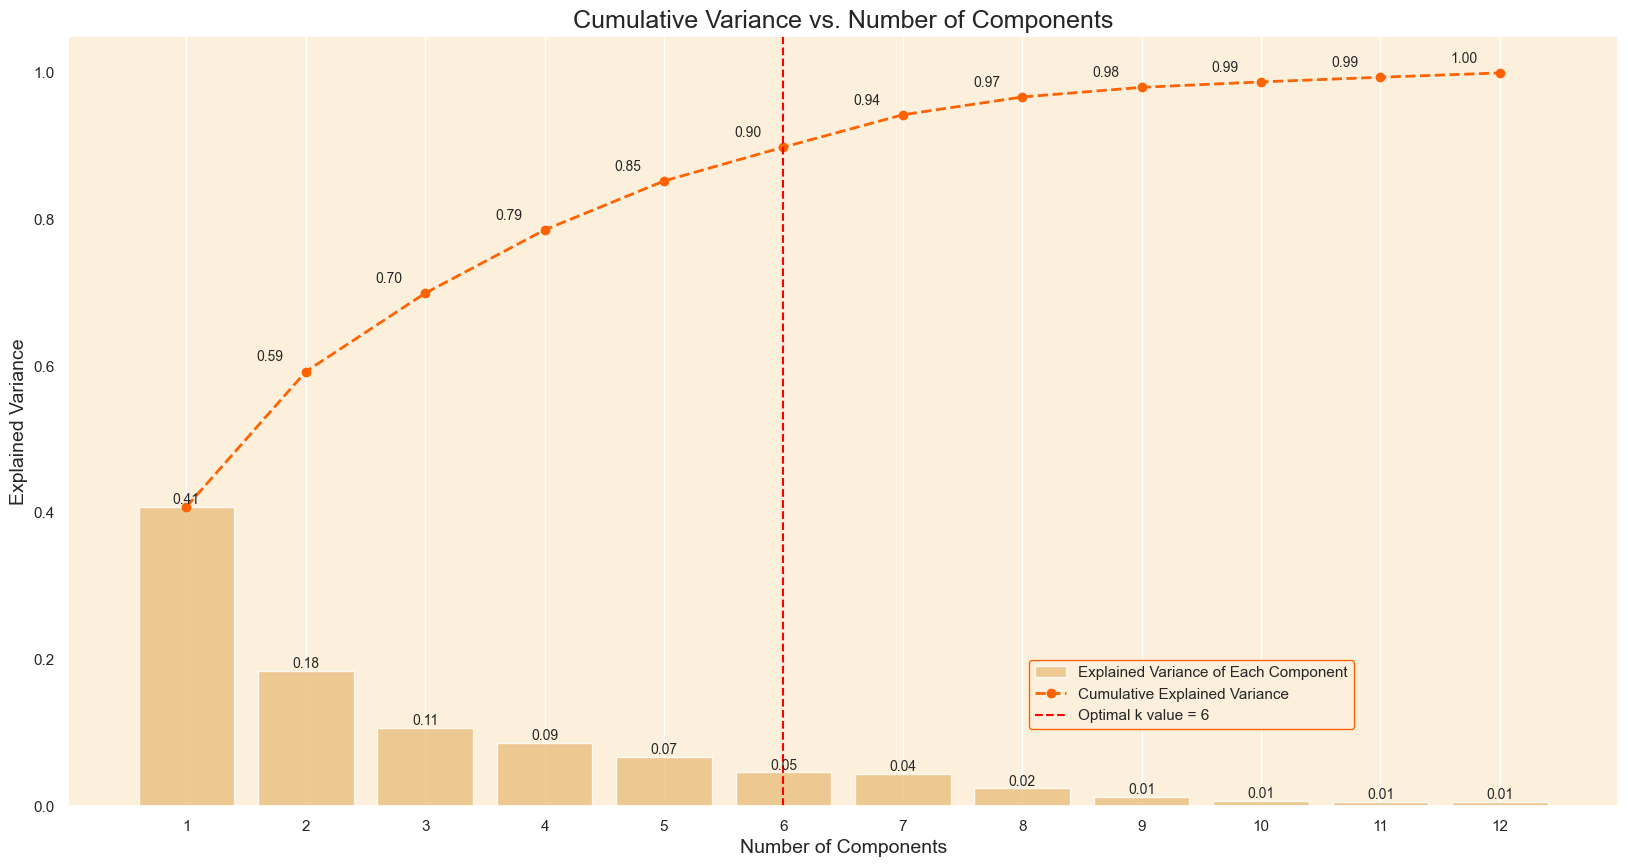

In [112]:
pca =PCA().fit(customer_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

optimal_k=6

sns.set(rc={'axes.facecolor':'#fcf0dc'},style='darkgrid')

plt.figure(figsize=(20,10))

barplot= sns.barplot(x=list(range(1,len(cumulative_explained_variance)+1)),
                     y=explained_variance_ratio,
                     color='#fcc36d',
                     alpha=0.8)

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [124]:
pca= PCA(n_components=6)
customer_data_pca= pca.fit_transform(customer_data_scaled)
customer_data_pca= pd.DataFrame(customer_data_pca,columns=['PC'+str(i+1) for i in range(pca.n_components_)])
customer_data_pca.index=customer_data_scaled.index
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
customerid,,,,,,
12346.0,-2.309199,-1.520713,-1.634860,-0.523483,-0.944116,-1.704848
12347.0,3.192271,-1.670956,1.998334,0.676769,0.430375,0.958035
12348.0,0.674337,0.513417,0.653051,0.361625,0.029832,2.598876
12349.0,1.471136,-2.916501,6.023090,-0.577609,0.273499,-1.654139
12350.0,-2.026054,-0.412933,0.492799,0.315474,-1.538141,0.374386


In [125]:
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

In [126]:

pc_df= pd.DataFrame(pca.components_.T,columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                                                index=customer_data_scaled.columns)

In [127]:


pc_df.style.apply(highlight_top3,axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
last_date_transaction,-0.218512,0.005272,0.053009,-0.117092,-0.375856,-0.340329
total_transactions,0.384107,-0.012194,-0.248869,0.123661,0.019337,-0.033099
total_products_porchased,0.403259,-0.021947,0.072460,0.107493,0.087681,-0.002695
total_spend,0.429774,-0.022245,0.066027,0.082084,0.050336,-0.032172
average_transaction_value,0.156888,-0.034979,0.600433,-0.073354,-0.019496,-0.093912
unique_products_purchased,0.335427,0.040347,0.011954,0.240250,-0.093103,0.142161
average_days_between_purchases,-0.026824,-0.027969,-0.140954,-0.113066,0.764534,0.163934
day_of_week,0.043312,0.994369,0.010079,-0.030633,0.038769,-0.065711
hour,-0.013020,0.057568,-0.008346,0.277634,-0.368641,0.770971
uk,0.001535,0.006770,-0.018357,0.007284,-0.001768,0.016947


In [128]:
%pip install setuptools

Note: you may need to restart the kernel to use updated packages.


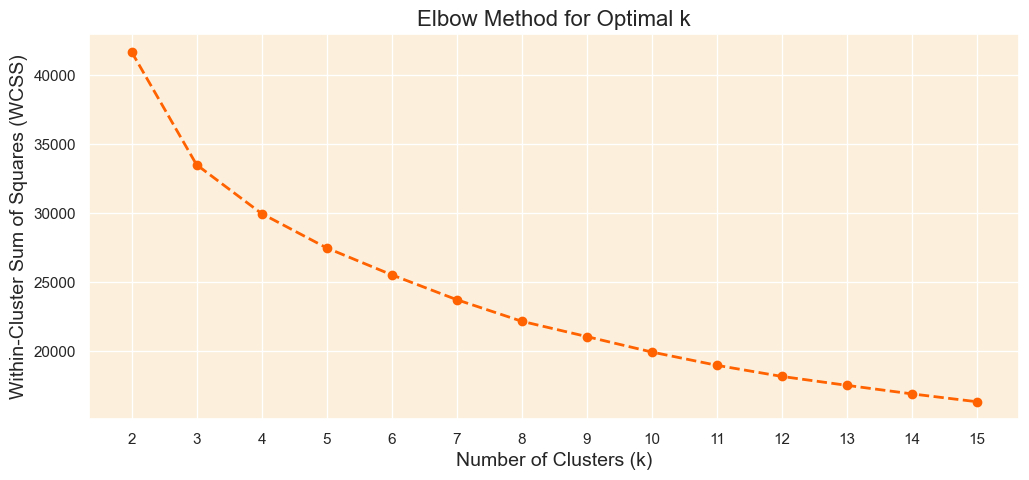

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})
sns.set_palette(['#ff6200'])

km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

wcss = []

for k in range(2, 16):
    km.set_params(n_clusters=k)  # Set number of clusters
    km.fit(customer_data_pca)     # Fit the model
    wcss.append(km.inertia_)      # Append the WCSS (inertia)

plt.figure(figsize=(12, 5))
plt.plot(range(2, 16), wcss, marker='o', color='#ff6200', linestyle='--', linewidth=2)
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
plt.xticks(range(2, 16))  # Set x-axis to match the range of k values
plt.grid(True)
plt.show()

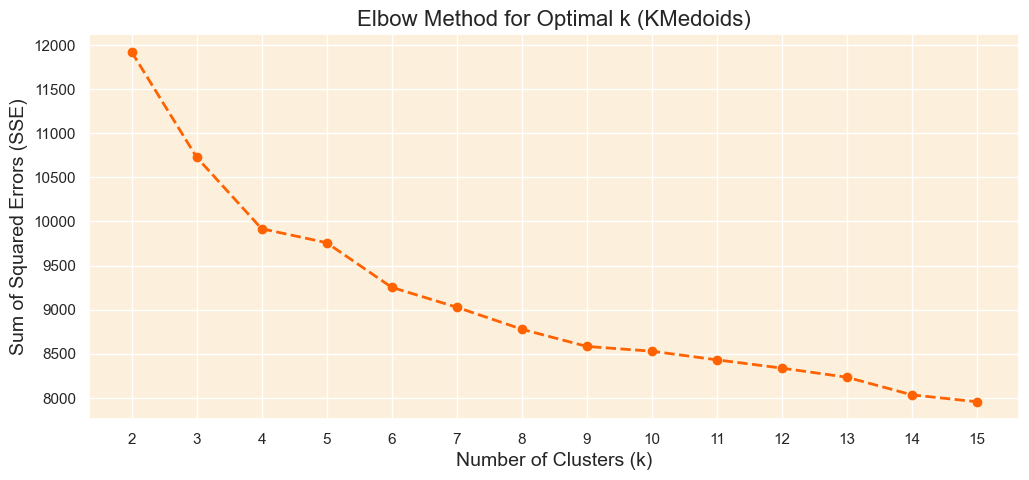

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids

# Set plot style
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})
sns.set_palette(['#ff6200'])

# Khởi tạo mô hình KMedoids với các tham số mặc định
km1 = KMedoids(init='k-medoids++', max_iter=100, random_state=0)

# Prepare to store SSE (sum of squared errors) for each k
sse = []

# Calculate SSE for k values from 2 to 15
for k in range(2, 16):
    km1.set_params(n_clusters=k)  # Set number of clusters
    km1.fit(customer_data_pca)     # Fit the model
    sse.append(km1.inertia_)      # Append the SSE (similar to inertia in KMeans)

# Plot the SSE to visualize the elbow
plt.figure(figsize=(12, 5))
plt.plot(range(2, 16), sse, marker='o', color='#ff6200', linestyle='--', linewidth=2)
plt.title('Elbow Method for Optimal k (KMedoids)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize=14)
plt.xticks(range(2, 16))  # Set x-axis to match the range of k values
plt.grid(True)
plt.show()

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.gridspec as gridspec  # Agrega esta importación


def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    plt.figure(figsize=figsize)

    grid = plt.GridSpec(stop_k - start_k + 1, 2)

    first_plot = plt.subplot(grid[0, :])

    sns.set_palette(['darkorange'])

    silhouette_scores = []
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.labels_

        row_idx, col_idx = divmod(i - start_k, 2)

        ax = plt.subplot(grid[row_idx + 1, col_idx])

        sample_silhouette_values = silhouette_samples(df, labels)

        y_lower = 10
        for j in range(i):
            cluster_silhouette_values = sample_silhouette_values[labels == j]
            cluster_silhouette_values.sort()

            size_cluster = len(cluster_silhouette_values)
            y_upper = y_lower + size_cluster

            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, 
                             facecolor=colors[j % len(colors)], edgecolor=colors[j % len(colors)], alpha=0.7)

            ax.text(-0.05, (y_lower + y_upper) / 2, f'Cluster {j + 1}', color='white', fontsize=12)

            y_lower = y_upper
            avg_score = np.mean(sample_silhouette_values)
            ax.axvline(x=avg_score, color='red', linestyle='--')
            ax.text(0.97, 0.02, f'Silhouette Score: {avg_score:.2f}', 
                    fontsize=12, ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)
        ax.set_xlabel('Silhouette coefficient')
        ax.set_ylabel('Cluster')

    plt.tight_layout()
    plt.show()

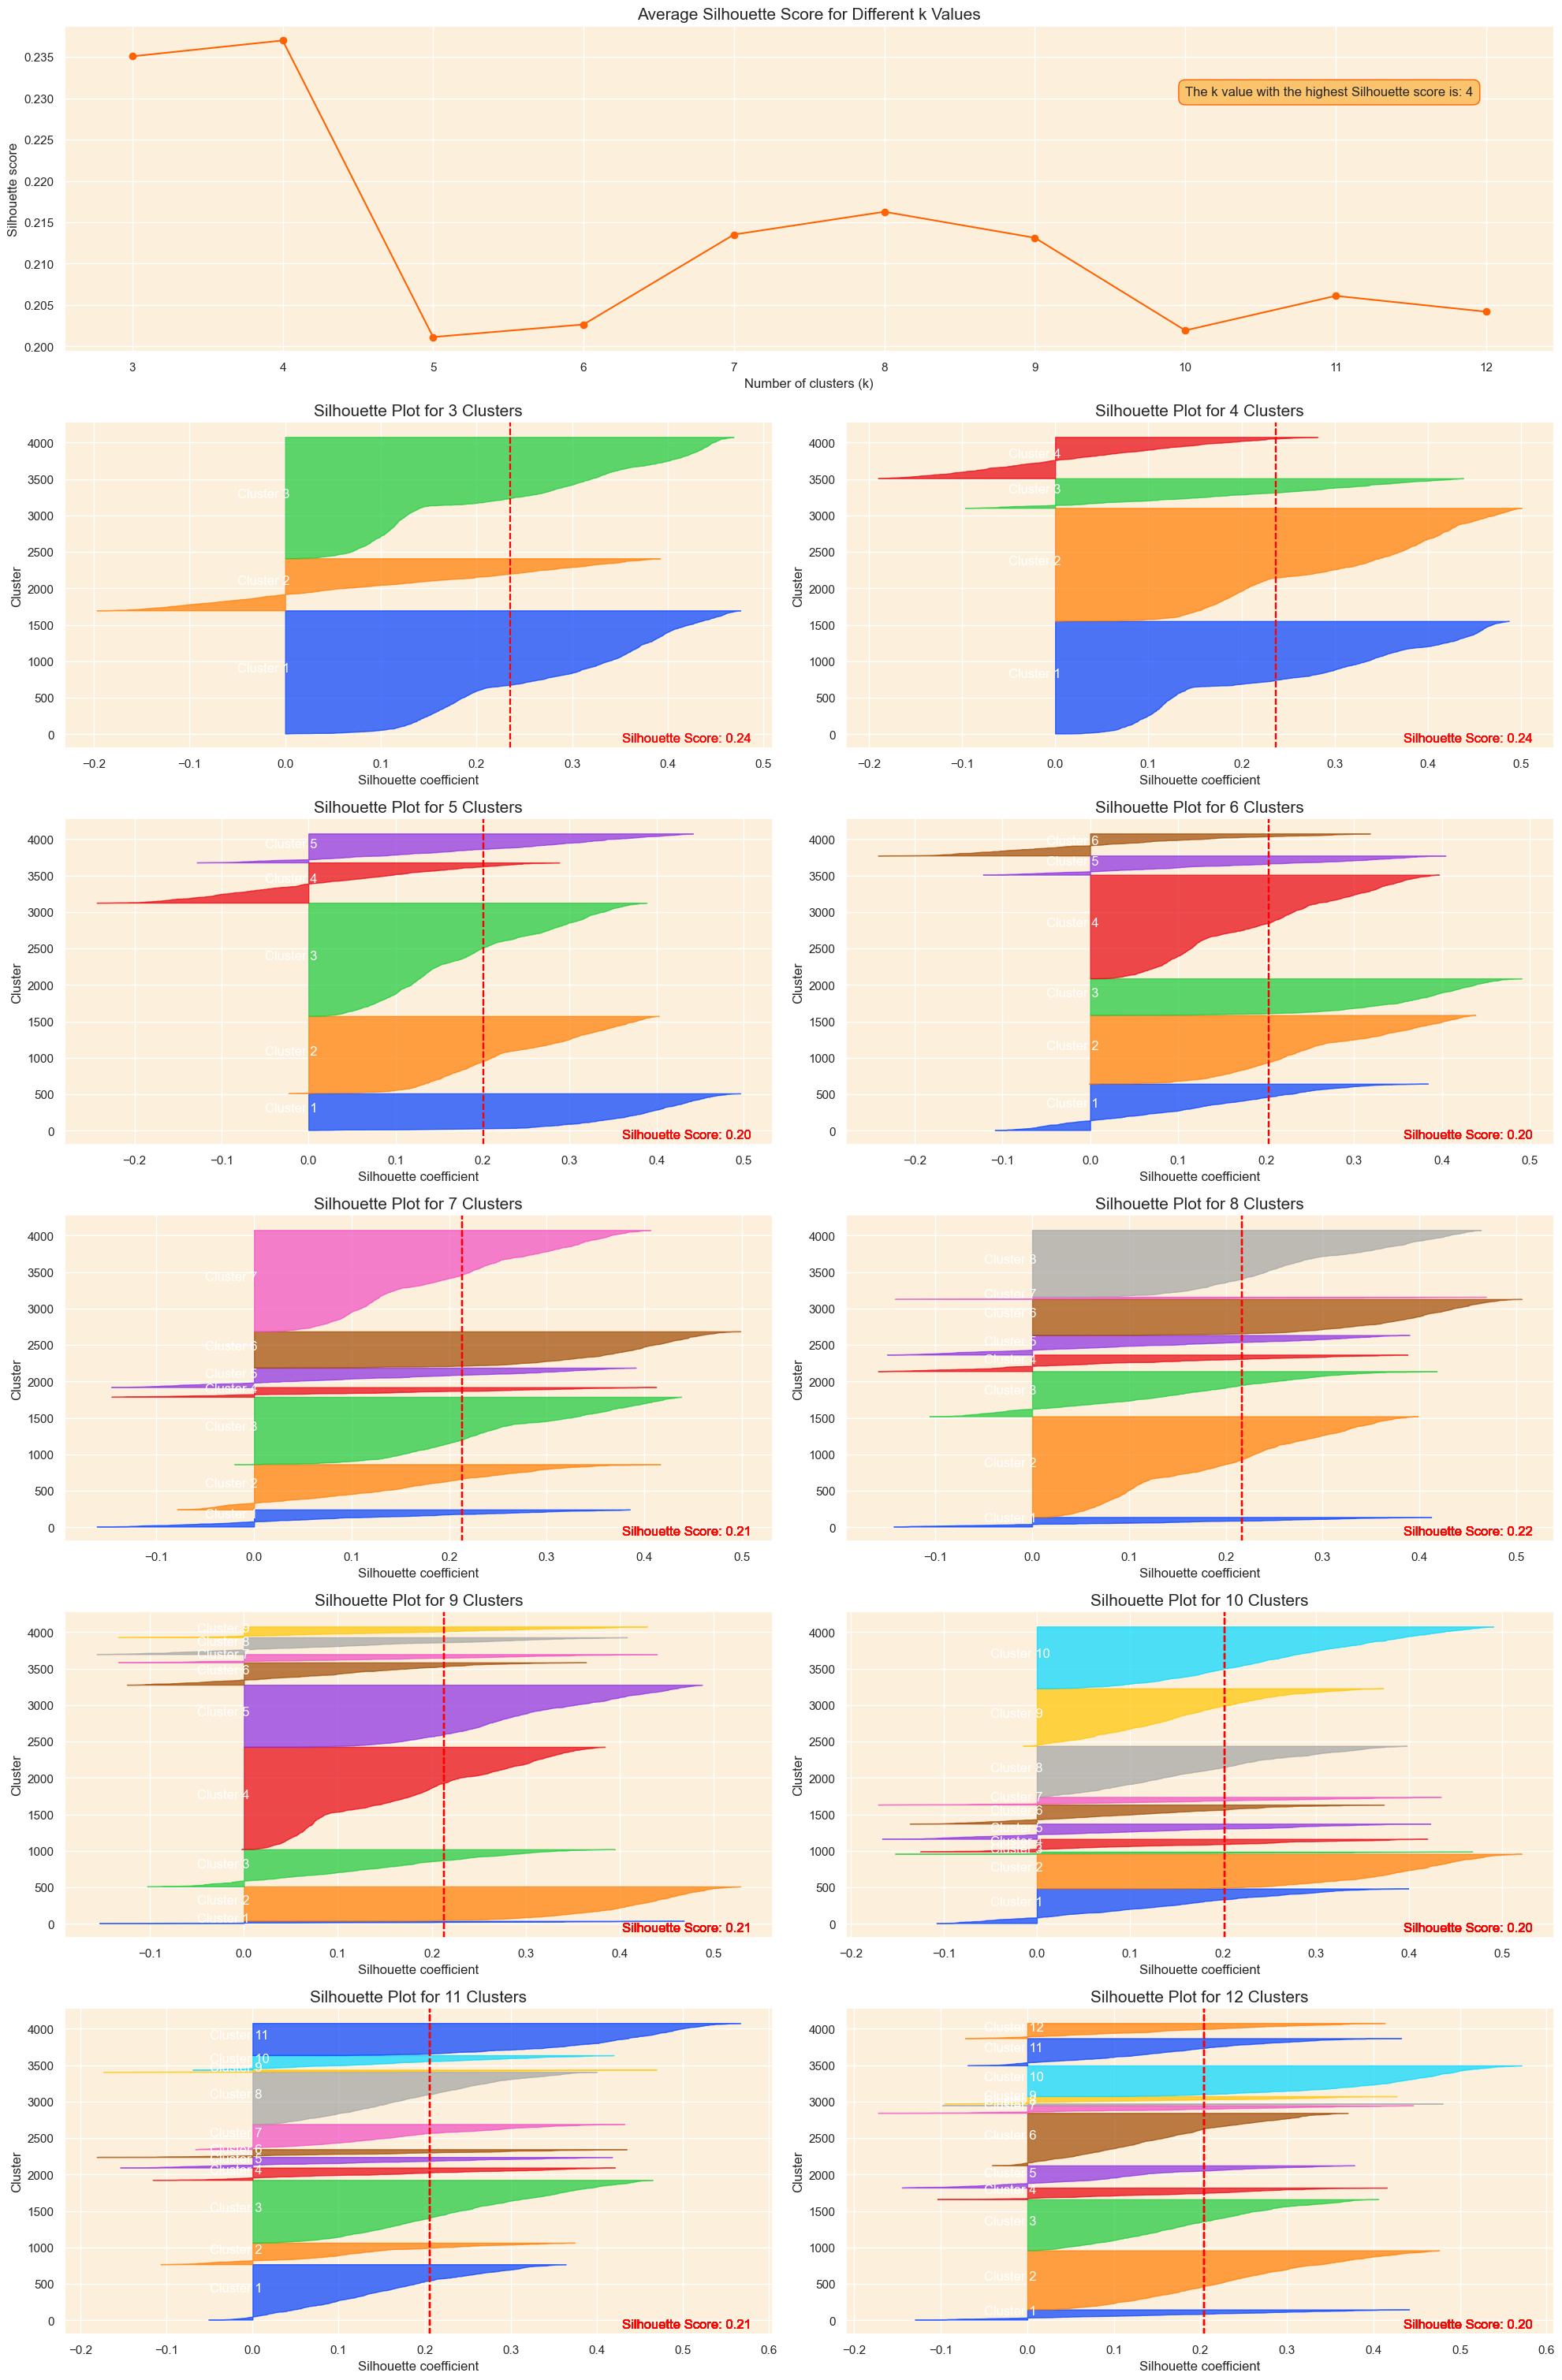

In [132]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

In [133]:
kmeans= KMeans(n_clusters=3,init='k-means++', n_init=10,max_iter=100,random_state=42)
kmeans.fit(customer_data_pca)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=42)

In [134]:
from collections import Counter

In [135]:
cluster_frequencias= Counter(kmeans.labels_)

In [136]:
print(int(cluster_frequencias[0])+int(cluster_frequencias[1])+int(cluster_frequencias[2]))
print(customer_data_pca.shape[0])

4067
4067


In [137]:
label_mapping={label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencias.most_common())}

In [138]:
label_mapping

{np.int32(0): 0, np.int32(2): 1, np.int32(1): 2}

In [139]:
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

In [140]:
label_mapping

{1: 2, 0: 1, 2: 0}

In [141]:
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

In [142]:
total_data_cleaned['cluster'] = new_labels

In [143]:
customer_data_pca['cluster'] = new_labels

In [144]:
total_data_cleaned.head()

,customerid,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


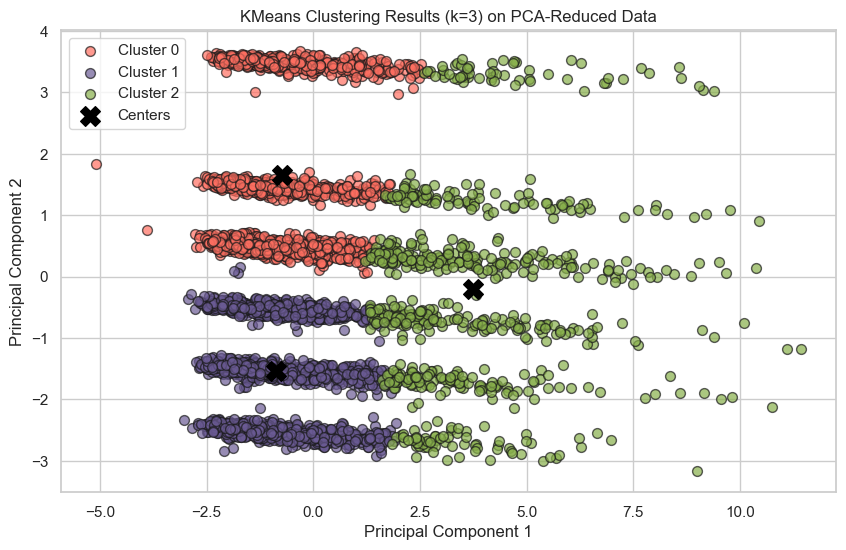

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')
colors = ['#FF6F61', '#6B5B95', '#88B04B'] 
plt.figure(figsize=(10, 6))
for i, color in enumerate(colors):
    cluster_data = customer_data_pca[customer_data_pca['cluster'] == i]
    plt.scatter(
        cluster_data.iloc[:, 0], 
        cluster_data.iloc[:, 1], 
        c=color, 
        label=f'Cluster {i}', 
        s=50, 
        alpha=0.7, 
        edgecolor='k' 
    )

centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0], centers[:, 1],
    c='black', s=200, marker='X', label='Centers'
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering Results (k=3) on PCA-Reduced Data')
plt.legend()
plt.show()

In [146]:
colors = ['#e8000b', '#1ac938', '#023eff']

In [147]:
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()
fig.write_html("3d_cluster_visualization.html")

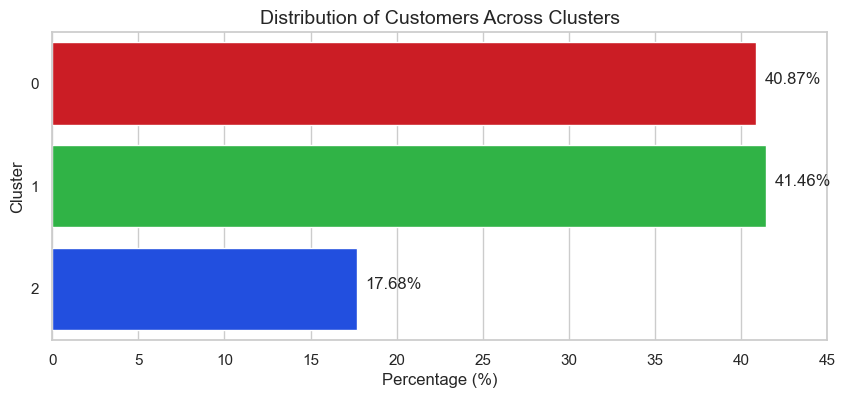

In [148]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

plt.show()

In [149]:
from tabulate import tabulate

In [ ]:
num_observations = len(customer_data_pca)

X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4067        |
|    Silhouette Score     | 0.2348878694684707 |
| Calinski Harabasz Score | 1263.2900594584764 |
|  Davies Bouldin Score   | 1.3777672421397036 |
+-------------------------+--------------------+
